In [1]:
import os, sys, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn_pandas import DataFrameMapper

#import lightgbm as lgb
#import optuna
#from optuna.integration import lightgbm_tuner
from optuna.integration import lightgbm as lgb

/Users/akihiro/anaconda3/envs/p37/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### load data

In [2]:
print(os.listdir('kuzushiji'))
classes = pd.read_csv('kuzushiji/kmnist_classmap.csv')

x_train = np.load('kuzushiji/kmnist-train-imgs.npz')['arr_0']
y_train = np.load('kuzushiji/kmnist-train-labels.npz')['arr_0']

x_test = np.load('kuzushiji/kmnist-test-imgs.npz')['arr_0']
y_test = np.load('kuzushiji/kmnist-test-labels.npz')['arr_0']

['kmnist-train-labels.npz', 'k49-train-imgs.npz', 't10k-images-idx3-ubyte', 'k49-test-labels.npz', 'k49_classmap.csv', 't10k-labels-idx1-ubyte', 'k49-train-labels.npz', 'kkanji', 'kmnist-test-imgs.npz', 'train-images-idx3-ubyte', 'kmnist-train-imgs.npz', 't10k-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz', 'k49-test-imgs.npz', 'train-labels-idx1-ubyte.gz', 'kmnist_classmap.csv', 'train-labels-idx1-ubyte', 'kmnist-test-labels.npz', 'kkanji.tar', 't10k-labels-idx1-ubyte.gz']


In [3]:
labelindex = classes.set_index('index').to_dict()['char']
print(labelindex)

{0: 'お', 1: 'き', 2: 'す', 3: 'つ', 4: 'な', 5: 'は', 6: 'ま', 7: 'や', 8: 'れ', 9: 'を'}


9
を


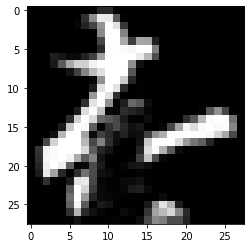

In [4]:
i = 101
plt.imshow(x_train[i], cmap=plt.cm.gray)
j = y_train[i]
print(j)
print(labelindex[j])

### Normalize and serialize

In [5]:
print(np.min(x_train), np.max(x_train), np.min(x_test), np.max(x_test))

x_train = x_train/x_train.max()
x_test = x_test/x_test.max()
print(np.min(x_train), np.max(x_train), np.min(x_test), np.max(x_test))

02550255
0.01.00.01.0


In [6]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
x_train = x_train.reshape(len(x_train), -1)
x_test = x_test.reshape(len(x_test), -1)
#y_train = y_train.reshape(len(y_train), -1)
#y_test = y_test.reshape(len(y_test), -1)

(60000, 28, 28)(10000, 28, 28)(60000,)(10000,)


In [7]:
lgb.LGBMClassifier()


/Users/akihiro/anaconda3/envs/p37/lib/python3.7/site-packages/optuna/integration/lightgbm_tuner/sklearn.py:36: UserWarning: LightGBMTuner doesn't support sklearn API. Use `train()` or `LightGBMTuner` for hyperparameter tuning.
  warnings.warn("LightGBMTuner doesn't support sklearn API. "


RuntimeError: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'optuna.integration.lightgbm_tuner.sklearn.LGBMClassifier'> with constructor (self, *args, **kwargs) doesn't  follow this convention.

In [0]:

# 訓練・テストデータの設定
train_data = lgb.Dataset(x_train, label=y_train)
eval_data = lgb.Dataset(x_test, label=y_test, reference= train_data)
 

In [0]:

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 10,
    'verbose': 2,
}
 

In [0]:

gbm = lgb.train(
    params,
    train_data,
    valid_sets=eval_data,
    num_boost_round=100,
    verbose_eval=5,
)


### optuna

In [0]:
def objective(trial):

    classes = pd.read_csv('kuzushiji/kmnist_classmap.csv')

    x_train = np.load('kuzushiji/kmnist-train-imgs.npz')['arr_0']
    x_test = np.load('kuzushiji/kmnist-test-imgs.npz')['arr_0']
    x_train = x_train/x_train.max()
    x_test = x_test/x_test.max()
    x_train = x_train.reshape(len(x_train), -1)
    x_test = x_test.reshape(len(x_test), -1)
    
    y_train = np.load('kuzushiji/kmnist-train-labels.npz')['arr_0']
    y_test = np.load('kuzushiji/kmnist-test-labels.npz')['arr_0']

    labelindex = classes.set_index('index').to_dict()['char']

#    data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
#    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25)
    dtrain = lgb.Dataset(x_train, label=y_train)
    params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 10,
#    'verbose': 2,
    'num_leaves': trial.suggest_int('num_leaves', 2, 256),
    }
#
#    param = {
#        'objective': 'binary',
#        'metric': 'binary_logloss',
#        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
#        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
#        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#    }
 
    gbm = lgb.train(params, dtrain)
    preds = gbm.predict(x_test)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(y_test, pred_labels)
    return accuracy
 
#study = optuna.create_study(direction='maximize')
study = optuna.create_study()
study.optimize(objective, n_trials=100)

best_params, tuning_history = dict(), list()
booster = lgb.train(params, dtrain, valid_sets=dval,
                    verbose_eval=0,
                    best_params=best_params,
                    tuning_history=tuning_history)
 


print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [20]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 10,
#    'verbose': 2,
}

classes = pd.read_csv('kuzushiji/kmnist_classmap.csv')

x_train = np.load('kuzushiji/kmnist-train-imgs.npz')['arr_0']
x_test = np.load('kuzushiji/kmnist-test-imgs.npz')['arr_0']
x_train = x_train/x_train.max()
x_test = x_test/x_test.max()
x_train = x_train.reshape(len(x_train), -1)    
x_test = x_test.reshape(len(x_test), -1)
    
y_train = np.load('kuzushiji/kmnist-train-labels.npz')['arr_0']
y_test = np.load('kuzushiji/kmnist-test-labels.npz')['arr_0']

x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train,
                                                shuffle=True,
                                                random_state=42)

labelindex = classes.set_index('index').to_dict()['char']

#    data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
#    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25)


lgb_train = lgb.Dataset(x_tr, y_tr)
lgb_valid = lgb.Dataset(x_val, y_val, reference=lgb_train)

best_params, tuning_history = dict(), list()
booster = lgb.train(params, lgb_train, valid_sets=lgb_valid,
                    verbose_eval=0,
                    best_params=best_params,
                    tuning_history=tuning_history)
print("Best Params:", best_params)
print("Tuning history:", tuning_history) 


tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s][W 2020-01-23 00:30:27,801] Setting status of trial#0 as TrialState.FAIL because of the following error: KeyError('binary_logloss')
Traceback (most recent call last):
  File "/Users/akihiro/anaconda3/envs/p37/lib/python3.7/site-packages/optuna/study.py", line 569, in _run_trial
    result = func(trial)
  File "/Users/akihiro/anaconda3/envs/p37/lib/python3.7/site-packages/optuna/integration/lightgbm_tuner/optimize.py", line 240, in __call__
    val_score = self._get_booster_best_score(booster)
  File "/Users/akihiro/anaconda3/envs/p37/lib/python3.7/site-packages/optuna/integration/lightgbm_tuner/optimize.py", line 142, in _get_booster_best_score
    val_score = booster.best_score[valid_name][metric]
KeyError: 'binary_logloss'


KeyError: 'binary_logloss'

In [0]:
def objective(trial):
    x = trial.suggest_uniform('x', -5, +15)
    return - math.exp(-(x - 2) ** 2) + math.exp(-(x - 6) ** 2 / 10) + 1 / (x ** 2 + 1)

def main():
    # 最適化のセッションを作る
    study = optuna.create_study()
    # 100 回試行する
    study.optimize(objective, n_trials=100)
    # 最適化したパラメータを出力する
    print('params:', study.best_params)
main()

In [0]:

optuna.integration.lightgbm_tuner.train(
    params,
    train_data,
    valid_sets=eval_data,
    num_boost_round=100,
    verbose_eval=5,
)

In [0]:
preds = gbm.predict(x_test)
y_pred = []
for x in preds:
    y_pred.append(np.argmax(x))
confusion_matrix(y_test, y_pred)



In [0]:
accuracy_score(y_test, y_pred)